In [4]:
%reload_ext autoreload
%autoreload 2
import os
import numpy as np
import sys
import pandas as pd
import sqlite3
import multiprocessing
sys.path.append("./MSongsDB/PythonSrc")
import hdf5_getters
import tables
from tqdm import tqdm
import matplotlib.pyplot as plt
from map_helpers import *
from sklearn.feature_extraction import DictVectorizer
from sklearn.decomposition import LatentDirichletAllocation

#Used to convert 2 coding into 3 coding for countries
import pycountry

#Can be used to map location to countries using google (or other search platform) requests
import geocoder

#Can be used to scrap location infos 
import wikipedia as wiki #used

#Mapping Lat/Long to country
import reverse_geocoder as rg #used

#Interactive vis : vis. data on map
import json #used
import folium #used
from folium import plugins #used
import branca #used

#Plot data
import seaborn as sns #used
from helpers import *
from spotify import *
from sklearn.decomposition import PCA

%matplotlib inline  


For a better vizualisation of this notebook please read it using the [notebook viewer](https://nbviewer.jupyter.org/github/cgallay/Ada/blob/master/Project/Projet_ADA_M2.ipynb)

# Introduction to the million song Dataset

According to the web site :  https://labrosa.ee.columbia.edu/millionsong "The Million Song Dataset is a freely-available collection of audio features and metadata for a million contemporary popular music tracks.
The core of the dataset is the feature analysis and metadata for one million songs, provided by The Echo Nest. The dataset does not include any audio, only the derived features."

The entire dataset size is 280 GB. We however, based our first analysis on a subset of 10,000 songs (1%, 1.8 GB compressed) in order to apply our algorithms on the bigger one later.

You will see below the first steps of our approach on this dataset.

### Features description : 
The list of the 54 features present in the dataset, can be found here : https://labrosa.ee.columbia.edu/millionsong/pages/example-track-description
In order not to list them all we choose here to describe the one that seems reelevent to our project: 
 * **artist_mbtags: ** : is an array containing all tags received by this artist on musicbrainz.org
 * **artist_mbtags_count: ** raw tag count of the x tags this artist received on musicbrainz.org (array is of same length than artist_mbtags )
 * **artist_name:** 
 * **artist latitude:**	float	latitude	
 * **artist location:**	string	location name	
 * **artist longitude:** float	longitude
 * **artist_terms:** tags from The Echo Nest in float with range : [0:1]
 * **artist_terms_freq:** similar to mbtags_count but from Echo Nest in float with range : [0:1]  
 * **artist_terms_weight:** same shape as the two previous tags in float with range : [0:1]
 * **danceability:** danceability measure of this song according to The Echo Nest in float with range [0:1]
 * **energy**: energy from listener point of view in float
 * **loudness:** the overall loudness of a track in decibels (dB). Loudness values in the Analyzer are averaged across an entire track and are useful for comparing relative loudness of segments and tracks. Loudness is the quality of a sound that is the primary psychological correlate of physical strength (amplitude).
 * **song_hotttnesss:** according to The Echo Nest, when downloaded (in December 2010) in float with range [0:1]
 * **segments_pitches** The key is a track-level attribute with range : [0:11] and corresponding to one of the 12 keys: C, C#, D, etc. up to B. If no key was detected, the value is -1. The mode is equal to 0 or 1 for “minor” or “major” and may be -1 in case of no result.
 * **segments_timbre** timbre is the quality of a musical note or sound that distinguishes different types of musical instruments, or voices. It is a complex notion also referred to as sound color, texture, or tone quality, and is derived from the shape of a segment’s spectro-temporal surface, independently of pitch and loudness.
 * **tempo:** tempo in BPM according to The Echo Nest
 * **title**
 * **year:** when this song was released, according to musicbrainz.org
 
 


# Importing Data
In order to import the data we used a function present in the file "hdf5_getters.py" from the git repository: https://github.com/tbertinmahieux/MSongsDB/blob/master/PythonSrc/hdf5_getters.py
We decided to import the whole subset and then converted it to a pickle format so that it would be easier and faster to load.
We modified slightly the python file so that every extracted features is directly decoded from utf-8 as we want it to be stored as string format instead of bytes.

Here we need to specify the path for our folder containing the Million song subset, which of course needs to be downloaded.
Furthermore, we specify a path were the songs will be stored in pickle format

In [5]:
# Paths fo reading the files

PATH_R = "../../AdaProject/MillionSongSubset/data"
len_R = len(PATH_R)

# Paths to store the pickle format file

PATH_P = "./pickle_data/complete_song_previews_url.pkl"

# Path containing additional files needed for example to extract the features names

PATH_hdf5 = "../../AdaProject/MillionSongSubset/AdditionalFiles/subset_msd_summary_file.h5"

In [6]:
#This function imports the the Data according to the folders downloaded from the million song dataset
#One has to decide which features (categories) we want to load
#Once imported it save it on the choosen folder

def get_song_data(categories, path=PATH_R, write=False,
                  write_path=PATH_P, start_i=0, end_i=10000):
    """ Pulls data from all h5 files on the provided path and all it's child nodes
    Parameters
    ---------
    categories: List/Strings
        Strings are specific keywords. For an example of available categories:
        http://labrosa.ee.columbia.edu/millionsong/pages/example-track-description
    path: String,optional
        Path to the h5 data to decode and compile
    write: Boolean,optional
        If true, writes data to .csv at 'write_path'
    write_path: String,optional
        Destination of the final compiled pandas Dataframe.
    Returns
    ------
    Pandas Dataframe containing categories
    """
# Conditional differentiates between different directory structures,
# anything less than 30 means the path is referencing a parent directory
    h5_files = [x for x in os.walk(path) if len(x[0]) == len_R+6 ]
    data, file_paths = [], []
    
    for root, dirs, files in h5_files:
        for f in files:
            file_paths.append(os.path.join(root, f))

    for file_path in tqdm(file_paths[start_i:end_i]):
        h5file = hdf5_getters.open_h5_file_read(file_path) 
        datapoint = {}
        for cat in categories:
            datapoint[cat] = getattr(hdf5_getters, "get_"+cat)(h5file)
        h5file.close()
        data.append(datapoint)

    df = pd.DataFrame(data)
    if write:
        try:
            df.to_pickle(write_path)
            print("Data written to {0}".format(write_path))
        except:
            print('Unable to write data')
    return df

In [7]:
#Load the features name from the metadata into a list so that we don't have to insert them manually

h5_summary = hdf5_getters.open_h5_file_read(PATH_hdf5)

metadata = h5_summary.get_node('/metadata/songs/').colnames
metadata.remove('genre')
metadata.remove('analyzer_version')
metadata = [w.replace('idx_', '') for w in metadata]

analysis = h5_summary.get_node('/analysis/songs/').colnames
analysis = [w.replace('idx_', '') for w in analysis]

musicbrainz = h5_summary.get_node('/musicbrainz/songs/').colnames
musicbrainz = [w.replace('idx_', '') for w in musicbrainz]

total_features = np.array(metadata + analysis + musicbrainz).ravel()

total_features = np.append(total_features, ['artist_terms_freq', 'artist_terms_weight', 'artist_mbtags_count'])


total_features = np.sort(total_features)
print("Total number of features: ",len(total_features))

Total number of features:  54


Once we have extracted the data from the subset with the help of the get_song_data() function, we can just load the data from the file created for later usage to gain time.

In [8]:
# Read and convert the data to a pickle format then load it from the pickle format

#df_song = get_song_data(total_features, write_path=PATH_P, write=True)
df_song = pd.read_pickle(PATH_P)

# Exploratory

### Year feature 
We started by checking the distribution of the song according to their year of realease

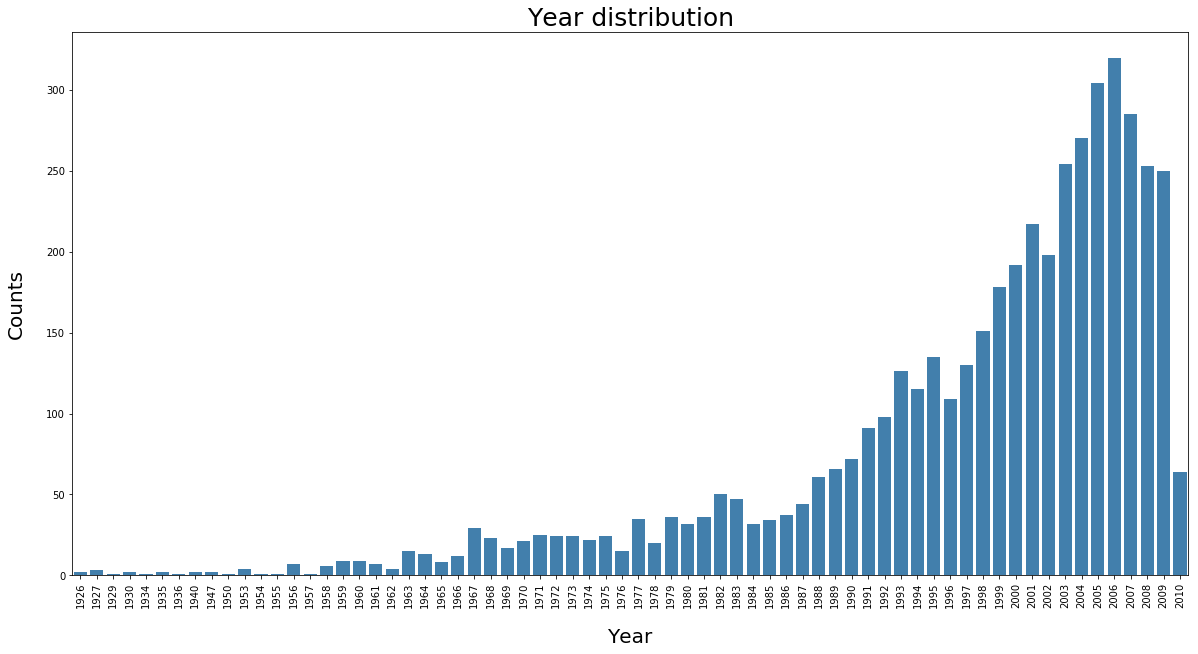

In [9]:
#Plot distribution by year
df = df_song[["artist_name","year"]].groupby('year').count().drop(0)

plt.figure(figsize=(20,10))
plt.xticks(rotation=90)
plot = sns.barplot(x=df.index, y=df.artist_name, color='#3182bd')
plot.set_title('Year distribution', fontsize= 25 )
plot.set_ylabel('Counts', fontsize=20, labelpad=20)
plot.set_xlabel('Year', fontsize=20, labelpad=20)
plt.savefig('../docs/images/year_distr.png')
plt.show()

Number of sample not containing value for the year feature

In [10]:
#Number of sample not containing value for the year
df_song[df_song.year == 0].count()[0]

5320

From this distribution we can see that the dataset contains much more sample starting from the 90's. This could be related to the emergence of the compact disc technology developed by Sony and Philips and launched in 1982 in which much more informations could be stored.
However, we can see bellow that the number of samples that do not contain a value for the feature "year" is not negligeable and represent almost half of our dataset. It will thus be necessary to take this into account analysing the whole dataset or find a way to extract this information from the web.

#### Dealing with missing values
As we are dealing with a lot of incomplete data, we want to find some strtagies to fill a maximum of missing values. For instance, we want to complete some geographical coordinates with help of the artist_location feature. Furthermore, dealing with the missing years would also increase a lot our analysis of the dataset. To do so, we will try to scrap as many information from wikipedia pages and use a reverse_geocoder library which allows us to find location informations with coordinates. We can then, add a country feature that are intersting.

### Location and longitude/latitude features

In order to represent some mean and distribution on a map, our first challenge was to map the location and coordinates to a country as the country feature was not present in the original dataset. To do so, we first started by using the library geocoder, used to map location to countries using google (or other search platform) queries. The problem was the limitation of free queries by day (2500). This could work with a dataset of 1000 sample but would not be suitable for the whole dataset.
We thus decided to start with mapping the geographic coordinates to countries using the library : reverse_geocoder.

In [11]:
#Check first how many entries contains latitude (longitude) infos
df_song["artist_latitude"].count()

3742

#### Trying to use wikipedia when only location given, DO NOT use yet as it is to time consuming and needs another approach

In [12]:
# Search coordinates given a location
def wiki_search(location):
    list_poss = wiki.search(location)
    pages = []
    for i, val in enumerate(list_poss):
        pages.append(wiki.WikipediaPage(list_poss[i]))
        # TODO check if all location are similar
    return (pages[0].coordinates[0], pages[0].coordinates[1])

In [13]:
# Map latitude/longitude to countries offline and completes Countries feature
def extend_countries_2(df):
    df_extended = df.copy()
    df_extended['Country'] = np.nan
    
    location_bool = [len(x)>0 for x in df_song.artist_location]
    coordinates_bool = [not x for x in df_song.artist_latitude.isnull()]
    
    
    indexes_location = df_song[location_bool].index
    indexes_with_cordinates = df_song[coordinates_bool].index

    for ind in tqdm(indexes_location):
        coord = None
        if ind in indexes_with_cordinates:
            coord = (df["artist_latitude"][ind],df["artist_longitude"][ind])
            result = rg.search(coord)
            df_extended.loc[ind, 'Country'] = result[0]['cc']

        else:
            try:
                coord = wiki_search(df.loc[ind, 'artist_location'])
            except:
                print(type(df.loc[ind, 'artist_location']), df.loc[ind, 'artist_location'])
                continue
                
            result = rg.search(coord)
            df_extended.loc[ind, 'Country'] = result[0]['cc']
            df_extended.loc[ind, 'longitude'] = result[0]['lon']
            df_extended.loc[ind, 'latitude'] = result[0]['lat']
        
    return df_extended

This is the simplified version of the above functions which only adds a feature Country to the dataset with help of the available coordinates.

In [14]:
# Map latitude/longitude to countries offline and completes Countries feature
def extend_countries(df):
    df_extended = df.copy()
    df_extended['Country'] = np.nan
    
    coordinates_bool = [not x for x in df_song.artist_latitude.isnull()]
    indexes_with_cordinates = df_song[coordinates_bool].index

    for ind in tqdm(indexes_with_cordinates):
        
        coord = (df["artist_latitude"][ind],df["artist_longitude"][ind])
        result = rg.search(coord)
        df_extended.loc[ind, 'Country'] = result[0]['cc']
        
    df_extended[['Country', 'title']].to_pickle('./temp/song_dataC', index=False) # modify path if necessary
    
    return df_extended

In [15]:
# Use this function when needing to complete the dataset. Afterwards just load the create pickle
#df_country = extend_countries(df_song)

Starting from here, we just load the partially completed (with countries dataset) in order to analyse the different distributions

In [16]:
df_country = pd.read_pickle("./temp/song_dataC")
print("number of different countries : ",df_country["Country"].value_counts().shape[0] )

number of different countries :  61


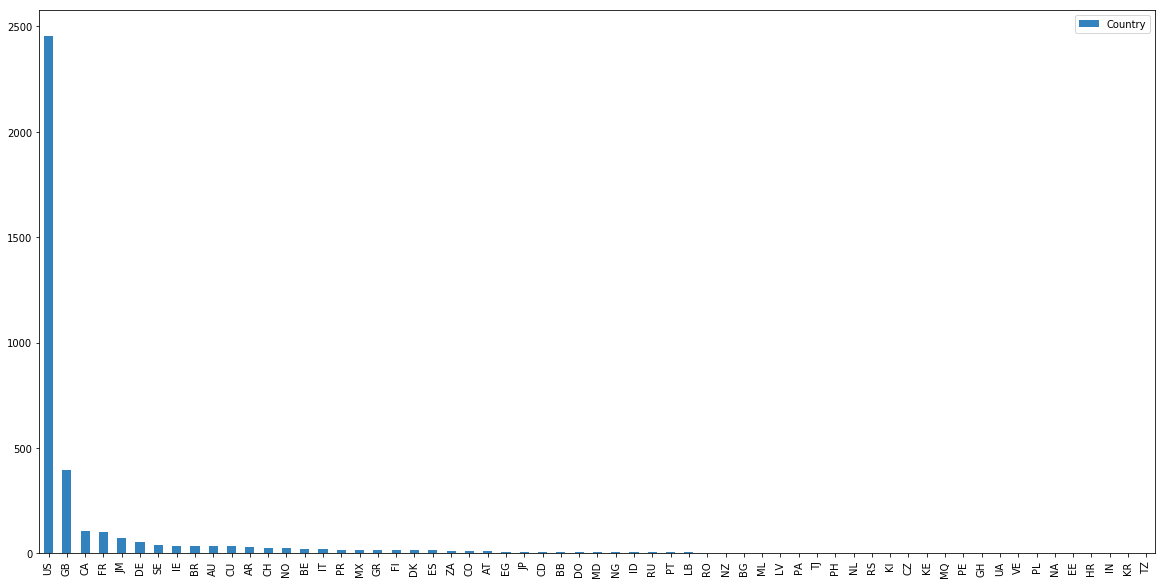

In [17]:
#Plot the ditribution by country
serie = df_country["Country"].value_counts()
pd.DataFrame(serie).plot(kind = "bar", color='#3182bd', figsize = (20, 10))

We can clearly see that the distribution for this subset is very concentrated in the english part (particularly for the US)
We will thus need, to take this information into account analysing mean and projection on maps. Moreover, we can see that only 60 countries are represented which is far for the total number of countries in the world.

### Song Hotness
As for the aim of this project will need to find a way to measure the success of the released songs and their type along the years, we first started by analysing and visualizing the "song_hotttnesss" feature computed by Echonest and its mean by country.


# Genre distribution on map

Here we want to have a look at distribution of artist per genre and per year, to see if it is possible to determine where genre where first recorded.

First of all we show bellow the distribution of artist in all time. We clearly see as already mention before a disproportion of location tag on song from our dataset. Most of the tags are either North America or in EU. As this wont let us detect musical style coming from Asia, South America or Africa, we should still be able to see from which side of the Atlantic the genre originate form.



In [18]:
#Distribution of all the dataset locations
artistDensityMap(selectData(df_song))

### Selecting genre

To detect the genre of a song we based our analysis on the `artist_terms` attribute. Unfortunately this feature doesn't directly contain the genre of the artist (song), but rather terms that people have associated with this artist, most of the time this terms do correspond to genre but they might also be noise (such as a city). An other drawback of this feature, is that there is a lot of different sub-genre. To deal with that, we performed LDA (Latent Dirichlet Analysis) to find 10 super-genre. 

In natural language processing, latent Dirichlet allocation (LDA) is a generative statistical model that allows sets of observations to be explained by unobservedgroups that explain why some parts of the data are similar. For example, in our case, if observations are terms in the list of each artist_terms feature's track, It would describe the feature as a mixture of a small number of topics and that each term's creation is attributable to one of the feature's topics. The topic here would be a genre and the aim here is thus to group the tags into bigger categories representing a type of music.

In order to match a certain track to a mixture of genre, we will use the above algorithm to be able to classify tags under a same genre abd find the following 10 topics. 
We can observe that the terms are, indeed, related to each other which is what we expected from the tags of a track.

In [19]:
vectorizer = DictVectorizer()
df_song["artist_terms_weight_"] = df_song["artist_terms_weight"] * 100
X_dict = df_song[["artist_terms", "artist_terms_weight_"]].apply(lambda x: dict(zip(np.array(x["artist_terms"]), np.array(x["artist_terms_weight_"]))), axis=1)
X = vectorizer.fit_transform(X_dict)

In [20]:
#Train the model
LDA = LatentDirichletAllocation(10, learning_method='batch', random_state=42)
%time X_tranform = LDA.fit_transform(X)

Wall time: 48.7 s


In [21]:
#Add the super genre to the DataFrame
df_song["genre"] = np.argmax(X_tranform, axis=1)
showMapWithTime(selectGenre(df_song, 2))

In [22]:
#Normalization is perform to give the same important to each genre (topic)
components_norm = LDA.components_ / LDA.components_.sum(axis=1)[:, np.newaxis]
res = sorted(zip(np.max(components_norm, axis=0), np.argmax(components_norm, axis=0), vectorizer.get_feature_names()), reverse=True)
d = [np.array(res)[np.array(res)[:, 1].astype(int) == i][:8][:, 2].tolist() for i in range(LDA.n_components)]
p = pd.DataFrame(d)
p.set_index(pd.Series(["Super genre "+str(i) for i in range(LDA.n_components)]))

,0,1,2,3,4,5,6,7
Super genre 0,reggae,dub,dancehall,roots reggae,ska,lovers rock,rock steady,jamaica
Super genre 1,pop,christian,ccm,gospel,spanish,male vocalist,latin pop,female vocalist
Super genre 2,instrumental,jazz,classical,easy listening,ambient,soundtrack,chill-out,new age
Super genre 3,rock,alternative,alternative rock,indie,punk,indie rock,hard rock,classic rock
Super genre 4,blues,blues-rock,soul,r&b,united states,smooth jazz,soul jazz,country blues
Super genre 5,latin,world,latin jazz,bossa nova,chanson,samba,comedy,salsa
Super genre 6,electronic,electro,techno,house,downtempo,trance,breakbeat,disco
Super genre 7,country,ballad,folk,soft rock,pop rock,singer-songwriter,country rock,oldies
Super genre 8,heavy metal,metal,hardcore,death metal,thrash metal,black metal,alternative metal,doom metal
Super genre 9,rap,hip hop,funk,gangster rap,urban,hardcore rap,new york,american


Below, we have a distribution of the genre

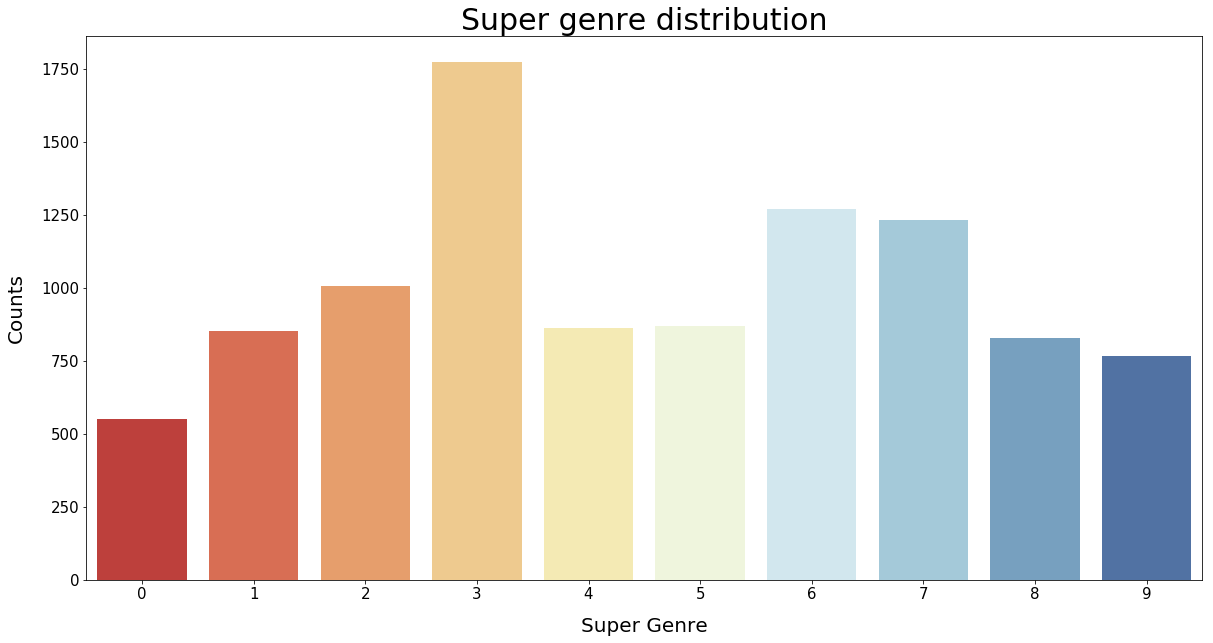

In [23]:
#Plot distribution by year
df = df_song[['genre', 'title']].groupby('genre').count()
#df= df.sort_values(by='title', ascending=False)

plt.figure(figsize=(20,10))

plot = sns.barplot(x=df.index, y=df.title, order=df.index, palette='RdYlBu')
plot.set_title('Super genre distribution', fontsize=30)
plot.set_ylabel('Counts', fontsize=20, labelpad=15)
plot.set_xlabel('Super Genre', fontsize=20, labelpad=15)
plot.xaxis.axes.tick_params(labelsize=15)
plot.yaxis.axes.tick_params(labelsize=15)

plt.savefig('../docs/images/genre_distr.png')
plt.show()

### Extending data through time

When vizualizing the song through time on the map we realised that a song only say one epoch (frame) visible. For us it doesn't reflect the reality as once a song is released it will perdure for a certain amount of time. To simulate that we extend our data with duplicate of the song up to 10 years after it's first apparition. We didn't want to naively duplicate the song as it wont stay a new song for 10 year long, to take that into account, as time pass we decrease the song weight (it's importance at representing the genre into the society)

In [24]:
showMapWithTimeAndWeight(extendsData(selectGenre(df_song, 6)))

In [25]:
len(selectGenre(df_song, 3))

436

# Next objectives:

Quick reminder of the direction we wanted to take at the beginning of our project: 
“The goal of this project is to discover how new styles of music emerge in society with respect to location, rapidity of trend propagation or also consistency in time of a style's popularity. Furthermore, we want to explore the influence of a hit/artist on other artists/styles.” 

We will thus still try to keep these objectives as it seems from our first approach that we could get some relevant results.

Our close objectives will be to find a way to fill efficiently the remaining missing data and deal with a bigger dataset.

In order to explore the influence of a hit/artiste on other artists/styles we decided that we would represent each song and artist under a vectorized form containing all the information relevant to them. We will thus have a closer look at the features no yet used as the “song_hotttnesss”, “loudness”, “segment_pitches” and “segment_timbre”.

This new look seems paving the way to a potential new utility for this project. Indeed, we would also like at the end offer the opportunity to the user, to try an original recommender system displayed on a webapp on which we are reflexing. It would play some audio sample from which the user will have to like or dislike. Based on that we would recommend her a type of music, similar artists, songs or even in which decade she should have been born.

## Summary list of internal milestones up to next milestone

*	Complete missing data
*	Handle bigger dataset
*	Vectorization and similarity computations (songs and artists)
*	Implementation of an original recommender system based on some machine learning




# Genre analysis trough space

Now, lets try to put our genre classification into another perspective. More precisely, we want to confront the given labeling (tags) of the songs with some of their content informations. To do that, we focused on these given features : "tempo","loudness","time_signature","mode" with respect to the our genre labeling.
However, we can see below, that the box plots for the features : “loudness”, “tempo” and “time signature” are not really relevant with respect to the defined genres.

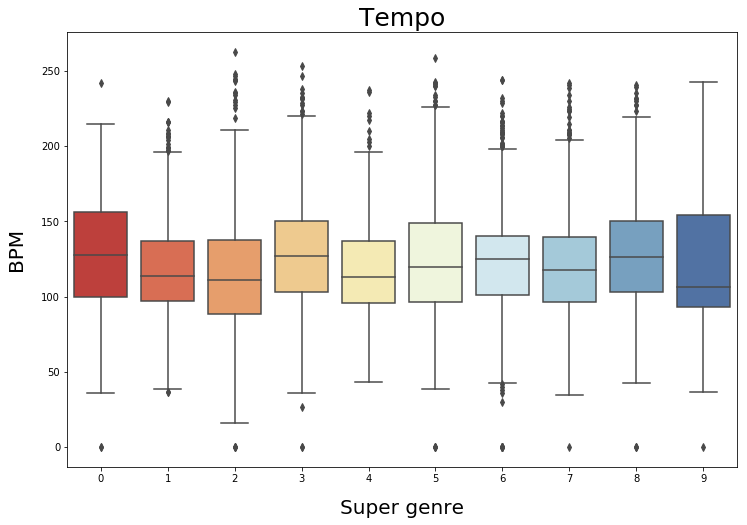

In [26]:
fig, ax = plt.subplots()
fig.set_size_inches(12, 8)
plot = sns.boxplot(x="genre", y = "tempo", data=df_song ,palette='RdYlBu', order=[0,1,2,3,4,5,6,7,8,9])

plot.set_title('Tempo', fontsize=25)
plot.set_ylabel('BPM', fontsize=20, labelpad=15)
plot.set_xlabel('Super genre', fontsize=20, labelpad=15)

plt.savefig('../docs/images/box_plot_tempo.png')

plt.show()

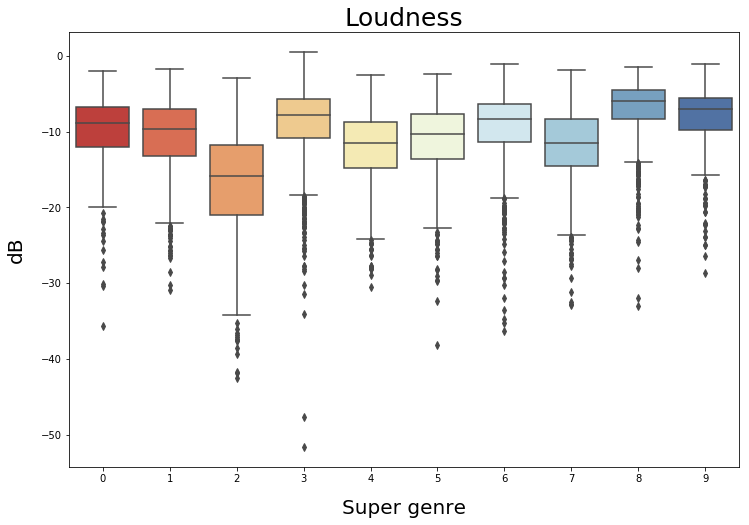

In [27]:
fig, ax = plt.subplots()
fig.set_size_inches(12, 8)

plot = sns.boxplot(x="genre", y = "loudness", data=df_song ,palette='RdYlBu')

plot.set_title('Loudness', fontsize=25)
plot.set_ylabel('dB', fontsize=20, labelpad=15)
plot.set_xlabel('Super genre', fontsize=20, labelpad=15)

plt.savefig('../docs/images/box_plot_loudness.png')

plt.show()


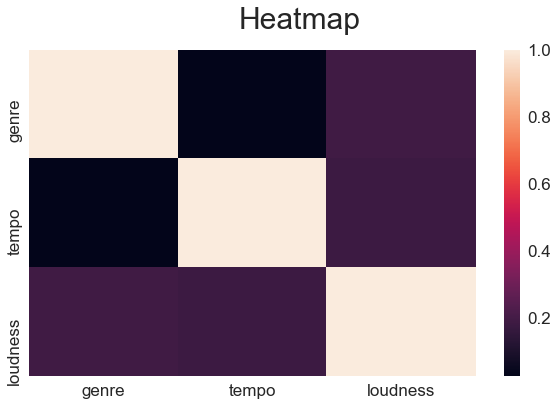

In [35]:
df4 = df_song[["genre","tempo","loudness"]].corr()
fig = plt.figure(figsize=(10,6))
fig.suptitle("Heatmap", size=30)

plot = sns.heatmap(df4, annot=False)
sns.set(font_scale=1.7)

plt.savefig('../docs/images/heatmap.png')

plt.show()

# PCA

In order to see if we could get information from it, we started by applying on the vectors of a given super genre, a principal component analysis (PCA). PCA, is a statistical procedure that uses an orthogonal transformation to convert a set of observations of possibly correlated variables into a set of values of linearly uncorrelated variables called principal components. We can see below, that the representation in space of two sets of songs, (coming from two different genre with respect to their two principal components values give some relevant results. Indeed, we can see well defined separation between the two music genre.

In [29]:
segmTimb39 =  df_song[["genre","segments_timbre"]][(df_song["genre"] == 3) | (df_song["genre"] == 9)]
X_content39 = segmTimb39.segments_timbre.apply(lambda m: np.mean(m, axis=0).tolist()).tolist()
X_content39 = np.array(X_content39)


In [30]:
pca = PCA(n_components = 2).fit_transform(X_content39)
pca.shape

(2538, 2)

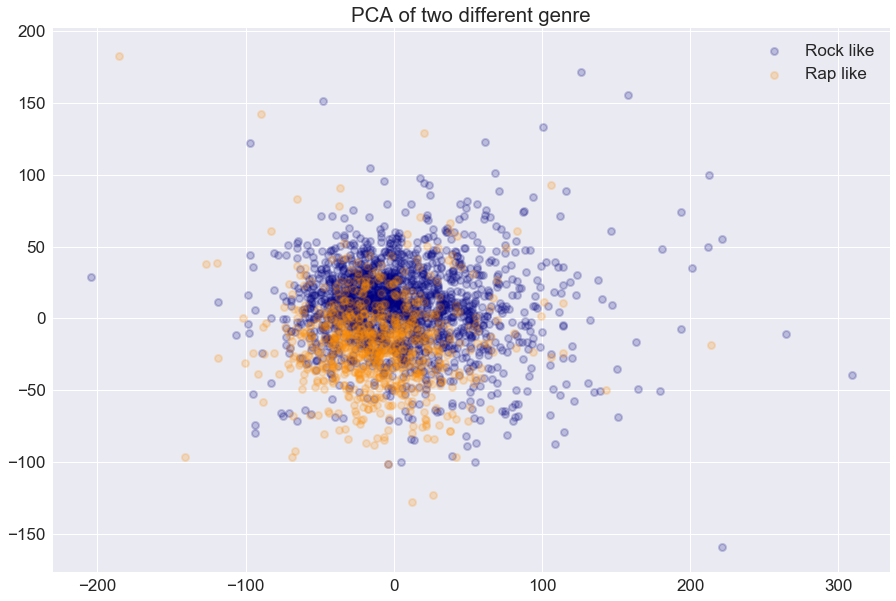

In [36]:
plt.figure(figsize=(15,10))
colors = ['navy', 'darkorange']
names = ["Rock like", "Rap like"]
y = segmTimb39["genre"]
lw = 2

for color, i, names in zip(colors, [3, 9], names):
    plt.scatter(pca[y == i, 0], pca[y == i, 1], color=color, alpha=.2, lw=lw, label = names)
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('PCA of two different genre')
plt.savefig('../docs/images/PCA_39.png')
plt.show()

# visualizing latent space

Using t-SNE the goal here is to plot the 2D space of song to see if we can see some clusters

We used another [TSNE](https://github.com/DmitryUlyanov/Multicore-TSNE) that works on multiple threads and which ist much faster than the simple TSNE from sklean. Please follow the instruction on there [github](https://github.com/DmitryUlyanov/Multicore-TSNE) to install it.

In [47]:
from sklearn.manifold import TSNE
#from MulticoreTSNE import MulticoreTSNE as TSNE
from sklearn.decomposition import PCA

In [38]:
%reload_ext autoreload
%autoreload 2
from helpers import *
from plot_helper import *

In [39]:
%time song_2d = TSNE(n_components=2, n_iter=250, random_state=42).fit_transform(X_tranform)

Wall time: 1min 2s


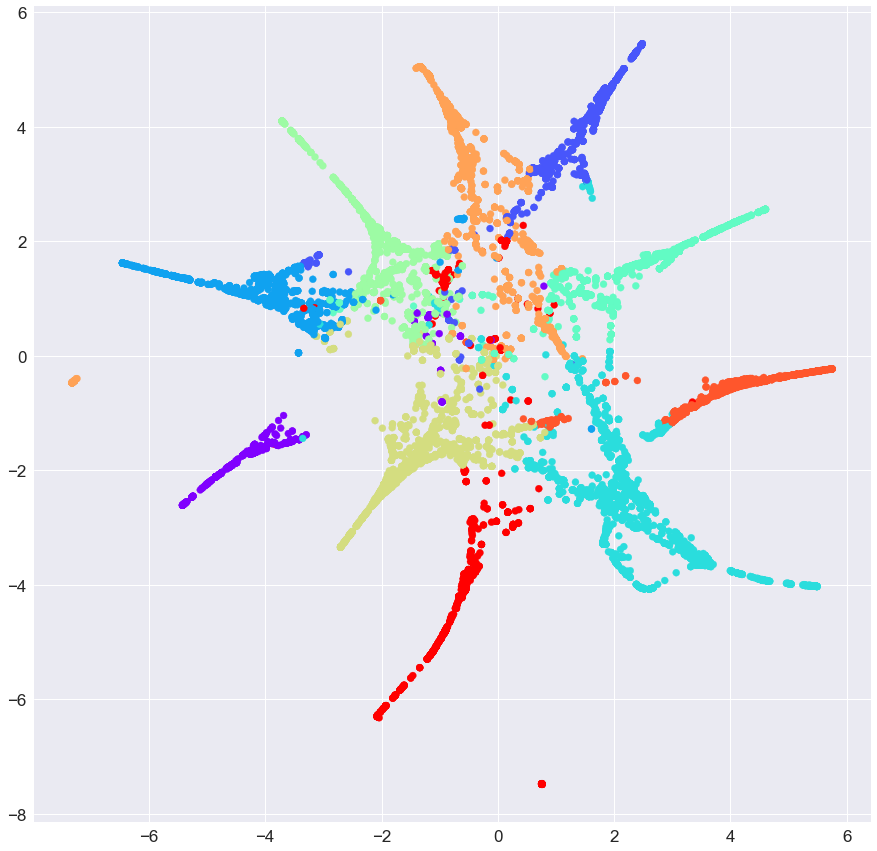

In [40]:
#colors = matplotlib.cm.rainbow(np.linspace(0, 1, 10))
#plt.figure(figsize=(15,15))
#plt.scatter(song_2d[:,0],song_2d[:,1], color=df_song["genre"].apply(lambda g: colors[g]).values)
colors = matplotlib.cm.rainbow(np.linspace(0, 1, 10))
plot2d_matplotlib(song_2d, df_song["genre"].apply(lambda g: colors[g]).values)

# Make it 3D


In [48]:
%time song_3d = TSNE(n_components=3, n_iter=250, random_state=42).fit_transform(X_tranform)

Wall time: 1min 43s


In [49]:
plot(song_3d, df_song["genre"].values, infos=df_song.apply(build_info, axis=1).values)

TypeError: 'NoneType' object is not subscriptable

# Content Base

In [ ]:
from scipy import stats
#timb1 = df_song.ix[0,"segments_timbre"]
#timb1M = np.mean(timb1,axis = 0)
#timb1M.shape
X_mean = np.array(df_song['segments_timbre'].apply(lambda m: np.mean(m, axis=0).tolist()).tolist())
X_std = np.array(df_song['segments_timbre'].apply(lambda m: np.std(m, axis=0).tolist()).tolist())
X_skew = np.array(df_song['segments_timbre'].apply(lambda m: stats.skew(m, axis=0).tolist()).tolist())
X_kurtosis = np.array(df_song['segments_timbre'].apply(lambda m: stats.kurtosis(m, axis=0).tolist()).tolist())
X_median = np.array(df_song['segments_timbre'].apply(lambda m: np.median(m, axis=0).tolist()).tolist())
X_content = np.concatenate([X_mean, X_std, X_skew, X_kurtosis, X_median], axis=1)
X_content.shape

In [ ]:
content_song_2d = TSNE(n_components=2, n_iter=250, random_state=42).fit_transform(X_content)

In [ ]:
#content_song_2d = PCA(n_components=2).fit_transform(X_content)

In [ ]:
plot2d_matplotlib(content_song_2d, df_song["genre"].apply(lambda g: colors[g]).values)

# Compress data using Autoencoder

In [ ]:
from keras.layers import Input, Dense
from keras.models import Model
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils
from keras import optimizers

encoding_dim = 20

input_features = Input(shape=(60,))
hidden1 = Dense(40, activation='relu')(input_features)
encoded = Dense(encoding_dim, activation='relu')(hidden1)
hidden2 = Dense(40, activation='relu')(encoded)
decoded = Dense(60)(hidden2)
autoencoder = Model(input_features, decoded)
encoder = Model(input_features, encoded)

adam_optim = optimizers.adam(lr=0.01)
autoencoder.compile(optimizer=adam_optim, loss='mean_squared_error')

In [ ]:
autoencoder.fit(X_content, X_content, validation_split=0.33, epochs=200)

In [ ]:
compressed = encoder.predict(X_content)

In [ ]:
compressed_song_2d = TSNE(n_components=2, n_iter=250, random_state=42).fit_transform(compressed)

In [ ]:
#compressed_song_2d = PCA(n_components=2).fit_transform(compressed)

In [ ]:
plot(compressed_song_2d, df_song['genre'], infos=df_song.apply(build_info, axis=1).values)

# Predict genre

In [ ]:
input_features = Input(shape=(60,))
hidden1 = Dense(40, activation='relu')(input_features)
hidden2 = Dense(40, activation='relu')(hidden1)
hidden3 = Dense(20, activation='relu')(hidden2)
out = Dense(10, activation='softmax')(hidden3)

latent = Model(input_features, hidden3)
genreModel = Model(input_features, out)
LDAModel = Model(input_features, out)

#genreModel.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
LDAModel.compile(loss='mean_squared_error', optimizer='adam')

In [ ]:
Y = df_song["genre"].values
Y = np_utils.to_categorical(Y)
Y = X_tranform

In [ ]:
LDAModel.fit(X_content[:5000], Y[:5000], validation_split=0.2, epochs=100, batch_size=10)

In [ ]:
predict = LDAModel.predict(X_content[5000:])
predict

In [ ]:
%time predict_song_2d = TSNE(n_components=2, n_iter=5000, random_state=42).fit_transform(predict)

In [ ]:
#predict_song_2d = PCA(n_components=2).fit_transform(predict)

In [ ]:
plt.figure(figsize=(15,15))
plt.scatter(predict_song_2d[:,0],predict_song_2d[:,1], color=df_song["genre"].apply(lambda g: colors[g]).values[5000:])

In [ ]:
plot(predict_song_2d, df_song["genre"].values[5000:], infos=df_song.apply(build_info, axis=1).values[5000:], filename='contentBased2D.html')

In [ ]:
#predict_song_3d = TSNE(n_components=3, n_iter=5000, random_state=42).fit_transform(predict)
%time predict_song_3d = TSNE(n_components=3, n_iter=5000, random_state=42).fit_transform(predict)

In [ ]:
plot(predict_song_3d, df_song["genre"].values[5000:], infos=df_song.apply(build_info, axis=1).values[5000:],urls=df_song.preview_url.values[5000:], filename='contentBased3D.html')

In [ ]:
#save into a div
plot2div(predict_song_3d, df_song["genre"].values[5000:], infos=df_song.apply(build_info, axis=1).values[5000:], urls=df_song.preview_url.values[5000:])

In [54]:
DIR_P = "./pickle_data/Filtered"

colsPart = {}
colsPart[1] = ['artist_latitude', 'artist_longitude', 'artist_terms', 'artist_terms_weight', 'year']
colsPart[2] = ['artist_hotttnesss', 'artist_name', 'artist_terms', 'artist_terms_weight',\
                   'loudness', 'song_hotttnesss', 'tempo', 'year', 'title',\
                  'X_mean', 'X_std', 'X_skew', 'X_kurtosis', 'X_median']

def read_pickle_filtered(letter, part, half):
    assert half in [1,2], "half must be either one or two"
    assert part in [1,2], "part must be either one to two"
    return pd.read_pickle(DIR_P + "/" + letter + "_part_" + str(part) + "_half_" + str(half) + ".pkl")

def merge_pickles(letters, part):
    df_merged = pd.DataFrame(columns=colsPart[part])
    for letter in letters:
        for half in [1,2]:
            df = read_pickle_filtered(letter, part=part, half=half)
            df_merged = df_merged.append(df)
    return df_merged
df_song = merge_pickles(['A', 'B', 'C', 'D', 'E', 'F'], 2)

In [55]:
df_song

,artist_hotttnesss,artist_name,artist_terms,artist_terms_weight,loudness,song_hotttnesss,tempo,year,title,X_mean,X_std,X_skew,X_kurtosis,X_median
2,0.405111,Harold Budd And Brian Eno,"[chill-out, meditation, space music, organic a...","[1.0, 0.99304796536, 0.992813107418, 0.9928131...",-31.359,0.409311,164.495,0,Failing Light (2004 Digital Remaster),"[21.1761363636, -190.243416667, -49.7279570707...","[4.63929892024, 48.0378883647, 47.4267492792, ...","[-0.496559771389, 2.94611391477, 0.45407133827...","[1.44244647534, 13.9570641748, -0.723403779173...","[20.7175, -196.282, -57.623, -43.0815, 96.3975..."
3,0.353960,Starbreaker,"[glam metal, power metal, heavy metal, progres...","[1.0, 0.96293777998, 0.95456651193, 0.94632947...",-4.724,0.449940,150.085,2005,Days Of Confusion,"[49.0484767255, 19.3680658106, 5.36618619583, ...","[5.79607244579, 70.9104698842, 31.5381845344, ...","[-1.73040933108, -0.710571865958, -0.307203331...","[7.59242533306, -0.293373298532, 0.34992020720...","[50.833, 42.324, 7.906, -12.757, -12.944, -23...."
4,0.308303,Whitney Cummings,"[stand-up comedy, comedy, funny, spoken word, ...","[1.0, 0.989845695313, 0.989060615789, 0.986769...",-4.314,0.215080,145.562,2009,Porn,"[51.4513736264, -12.2568278388, 98.9433699634,...","[2.98550577126, 41.0831702593, 47.590587703, 3...","[-1.50014587438, 0.155648193517, -0.1492630995...","[2.75638434618, 0.549749828698, -0.41479452420...","[52.185, -13.107, 103.72, 16.126, 44.968, -10...."
6,0.453543,Los Pericos,"[ska, reggae, tango, ska punk, latin pop, rock...","[1.0, 0.916614284378, 0.905812204902, 0.880011...",-7.068,0.401487,88.364,1998,La Mirada,"[45.6524798928, -28.7752698838, -13.2905093834...","[5.01893585623, 47.6888915227, 45.6082875642, ...","[-1.47695033572, -0.302030375511, -0.645377704...","[6.29999030636, 0.944374742451, 0.853534121807...","[46.402, -26.627, -8.438, -0.802, -8.198, -5.5..."
7,0.544615,K-Ci & JoJo,"[rock, urban, rap, romantic, vocal, classic, s...","[1.0, 0.949062952363, 0.706145757692, 0.678399...",-4.613,0.648628,111.237,2000,One More Mountain (Free Again),"[48.0456244842, 39.0500550206, -3.3483218707, ...","[5.46800721648, 39.6564114083, 38.850373778, 4...","[-2.68931643124, 0.304809378361, 0.39947487106...","[14.8577266255, 1.02843946013, 2.14491114286, ...","[49.055, 36.71, -4.225, -8.067, 7.953, -24.325..."
9,0.414636,The Sabres Of Paradise,"[trip hop, downtempo, breakbeat, big beat, pro...","[1.0, 0.969009744022, 0.958326756958, 0.952327...",-11.268,0.554282,151.814,1995,Planet D (Portishead Remix),"[36.7413372665, -124.934879056, -5.72767453294...","[6.11077386912, 80.6750316389, 49.7724618061, ...","[-0.641230016722, 0.590710126659, 0.8484086059...","[0.222624650854, -0.302746279763, 0.0223091601...","[37.853, -147.931, -14.587, 54.672, -6.018, 0...."
10,0.597793,Brand New,"[alternative, new york, grunge, classic, power...","[1.0, 0.999999570835, 0.71283464117, 0.6974758...",-5.826,0.700032,137.040,2001,Mix Tape,"[47.0136009036, -23.1705873494, 28.7887560241,...","[7.435330488, 66.8156559106, 26.9220419982, 32...","[-1.42372756242, -0.748045713289, -0.041472171...","[3.12535748055, 0.122011254673, 1.33922780369,...","[50.279, -8.626, 28.2075, -5.6035, -2.5245, -2..."
11,0.453850,EPMD,"[hip hop, big beat, old school hip hop, hardco...","[1.0, 0.981602542209, 0.892669925139, 0.878902...",-11.498,0.476248,173.423,1990,Mr. Bozack,"[42.5815606469, 36.2271657682, -40.5471401617,...","[3.13506065035, 46.3803685496, 41.5801918711, ...","[-3.46352584722, 0.0253506505567, 0.1849127331...","[44.6807833467, -0.389432373603, 0.05112306786...","[42.793, 35.0425, -40.2095, -20.628, 10.5255, ..."
13,0.303070,Harry Lauder,"[scottish, scottish folk, 00s, british, scotla...","[1.0, 0.777286304971, 0.59887252469, 0.5234005...",-20.554,0.220221,102.648,0,Wedding Of Sandy McNab,"[32.2293218707, -147.110969739, 80.8217262724,...","[3.98759715714, 43.1273282894, 38.6279909163, ...","[-0.878782282315, 1.02266063482, 0.18423394008...","[5.57723779376, 3.

In [ ]:
#df_deezer = add_previews_deezer(df_song, './pickle_data/complete_song_previews_url_Deezer_ABCDEF.pkl')
#df_spotify = add_previews_spotify(df_song, './pickle_data/complete_song_previews_url_ABCDEF.pkl')

In [ ]:
df_deezer = pd.read_pickle('./pickle_data/complete_song_previews_url_Deezer.pkl')

In [ ]:
df_spotify = pd.read_pickle('./pickle_data/complete_song_previews_url.pkl')

In [ ]:
df = complete_previews(df_deezer, df_spotify, './pickle_data/complete_song_previews_url_completed.pkl')